### Imports

In [ ]:
import matplotlib.pyplot as plt
import scipy.signal as sg
from scipy import stats
import numpy as np
import seaborn as sns
from neuropy import plotting
import tqdm.notebook as tqdm
import pandas as pd
import subjects

### Increase in gamma power during SD ?
- Interneurons play a key role in gamma generation. Since interneurons have elevated firing rate during sleep deprivation, does that affect gamma band. 

In [ ]:
sessions = subjects.sd.ripple_sess

psd_df = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    sd5 = [post[0] + 4 * 3600, post[0] + 5 * 3600]

    srate = sess.eegfile.sampling_rate
    # channel = sess.ripple.metadata["channels"][3]
    channel = sess.probegroup.get_connected_channels()[3][-1]
    kw = dict(fs=srate, nperseg=10 * srate, noverlap=9 * srate)

    labels = ["MAZE", "5th"]
    for i, e in enumerate([maze, sd5]):
        trace = sess.eegfile.get_signal(channel, *e).traces[0]
        f, pxx = sg.welch(trace, **kw)
        pxx = pxx * (0.95 * 1e-3) ** 2
        # b,a = sg.iirnotch(60,50,fs=1250)
        # trace = sg.filtfilt(b,a,trace)
        # trace = stats.zscore(trace)

        df = pd.DataFrame(dict(freqs=f, psd=pxx, zt=labels[i], grp=sess.tag))
        psd_df.append(df)

psd_df = pd.concat(psd_df, ignore_index=True)

In [ ]:
_, ax = plt.subplots()
sns.lineplot(data=psd_df, x="freqs", y="psd", hue="zt", ax=ax, ci=None)
ax.set_xscale("log")
# ax.set_yscale('log')

### Gamma band during sleep deprivation using wavelet

In [ ]:
from neuropy.utils.signal_process import WaveletSg, filter_sig, hilbertfast

sessions = subjects.sd.ripple_sess

hilamp = lambda arr: stats.zscore(np.abs(hilbertfast(arr)))
psd_df = []
for sub, sess in enumerate(sessions[2:3]):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    sd5 = [post[0] + 4 * 3600, post[0] + 5 * 3600]

    srate = sess.eegfile.sampling_rate
    # channel = sess.ripple.metadata["channels"][3]
    channel = sess.probegroup.get_connected_channels()[3][-1]
    kw = dict(fs=srate, nperseg=10 * srate, noverlap=9 * srate)

    signal = sess.eegfile.get_signal(channel, *sd5)
    slgamma = hilamp(filter_sig.bandpass(signal, lf=20, hf=50).traces[0])
    medgamma = hilamp(filter_sig.bandpass(signal, lf=62, hf=90).traces[0])


# psd_df = pd.concat(psd_df, ignore_index=True)

In [ ]:
_, axs = plt.subplots(2, 1)

xcorr = sg.correlate(slgamma, slgamma, mode="same")
t = np.linspace(-len(xcorr) / 2 / 1250, len(xcorr) / 2 / 1250, len(xcorr))
ax = axs[0]
ax.plot(slgamma)
ax.plot(medgamma)

ax = axs[1]
ax.plot(t, xcorr)

### Coherence during sleep deprivation

In [ ]:
sessions = subjects.sd.ratUday1

coher = []
for s, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    epochs = [
        [maze[0], maze[1]],
        [post[0], post[0] + 3600],
        [post[0] + 4 * 3600, post[0] + 5 * 3600],
        [post[0] + 5 * 3600, post[0] + 6 * 3600],
    ]

    channels = [100, 181]
    labels = ["maze", "1st", "5th", "rec"]
    for i, e in enumerate(epochs):
        sig1 = sess.eegfile.get_signal(channels[0], *e).traces[0]
        sig2 = sess.eegfile.get_signal(channels[1], *e).traces[0]
        f, cxy = sg.coherence(sig1, sig2, fs=1250, nperseg=2 * 1250, noverlap=1 * 1250)

        coher.append(pd.DataFrame(dict(freq=f, cxy=cxy, zt=labels[i])))

coher = pd.concat(coher, ignore_index=True)

In [ ]:
_, ax = plt.subplots()

sns.lineplot(data=coher, x="freq", y="cxy", hue="zt", ci=None)

ax.set_yscale("log")
ax.set_xscale("log")

### Inter hemisphere Gamma coupling during sleep deprivation


In [107]:
from neuropy.utils.signal_process import WaveletSg, filter_sig, hilbertfast

sessions = subjects.sd.ratUday1


def get_osc_params(arr):
    hil = hilbertfast(filter_sig.bandpass(arr, lf=62, hf=90, fs=1250))
    hilamp = stats.zscore(np.abs(hil))
    angle = np.angle(hil, deg=True) + 180
    return hilamp, angle


xcorr, phase_diff = [], []
for s, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    epochs = [
        [maze[0], maze[1]],
        [post[0], post[0] + 3600],
        [post[0] + 4 * 3600, post[0] + 5 * 3600],
        [post[0] + 5 * 3600, post[0] + 6 * 3600],
    ]

    # channels = [100, 181]
    channels = [96, 168]
    labels = ["maze", "1st", "5th", "rec"]
    for i, e in enumerate(epochs):
        sig1 = sess.eegfile.get_signal(channels[0], *e).traces[0]
        sig2 = sess.eegfile.get_signal(channels[1], *e).traces[0]

        gamma1, angle1 = get_osc_params(sig1)
        gamma2, angle2 = get_osc_params(sig2)
        xcorr_ = sg.correlate(gamma1, gamma2, mode="same")
        xcorr_ = xcorr_ / xcorr_.sum()
        n_t = len(xcorr_) / 1250 / 2
        t = np.linspace(-n_t, n_t, len(xcorr_))

        indx = (t > -0.5) & (t < 0.5)
        xcorr.append(pd.DataFrame(dict(t=t[indx], xcorr=xcorr_[indx], zt=labels[i])))

        angle_diff = angle2 - angle1
        bins = np.arange(-360, 360, 5)
        diff_hist = np.histogram(angle_diff, bins=bins)[0]
        phase_diff.append(
            pd.DataFrame(
                dict(
                    bins=bins[:-1] + 2.5,
                    p_diff=diff_hist / diff_hist.sum(),
                    zt=labels[i],
                )
            )
        )

xcorr = pd.concat(xcorr, ignore_index=True)
phase_diff = pd.concat(phase_diff, ignore_index=True)

<AxesSubplot:xlabel='bins', ylabel='p_diff'>

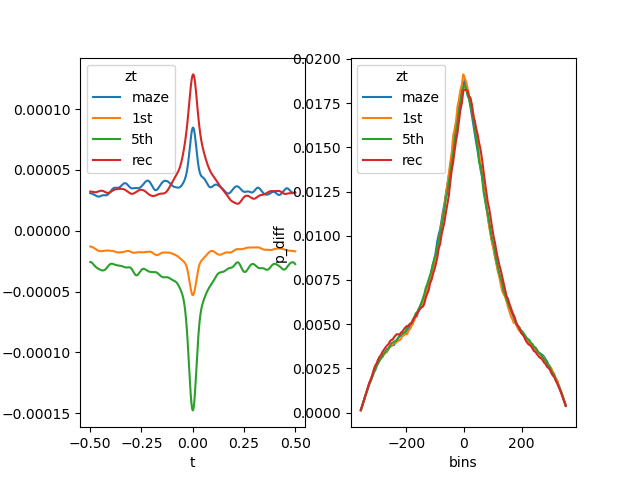

In [108]:
_, axs = plt.subplots(1, 2)

ax = axs[0]
sns.lineplot(data=xcorr, x="t", y="xcorr", hue="zt", ax=ax)

ax = axs[1]
sns.lineplot(data=phase_diff, x="bins", y="p_diff", ax=ax, hue="zt")

### PSD Gamma power comparison between SD and NSD REM sleep
- from whitened lfp spectrogram it appears that there maybe stronger gamma oscillation during REM of recovery sleep compared to REM of NSD sleep
- PSD analysis didn't reveal any significant difference

In [ ]:
# sessions = subjects.nsd.brainstates_sess + subjects.sd.brainstates_sess
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
import scipy.signal as sg
from scipy import stats

psd_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[1]]
    else:
        period = [post[0], post[0] + 5 * 3600]

    states = sess.brainstates.time_slice(period[0], period[1])["rem"]
    channel = sess.ripple.metadata["channels"][3]
    trace = sess.eegfile.get_frames_within_epochs(states, 82)
    b, a = sg.iirnotch(60, 50, fs=1250)
    trace = sg.filtfilt(b, a, trace)
    trace = stats.zscore(trace)

    f, psd = sg.welch(trace, fs=1250, nperseg=1250, noverlap=250)

    df = pd.DataFrame(dict(freqs=f, psd=psd, grp=sess.tag))
    psd_df.append(df)

psd_df = pd.concat(psd_df, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots()
sns.lineplot(data=psd_df, x="freqs", y="psd", hue="grp", ax=ax)
ax.set_xscale("log")
ax.set_yscale("log")

### Hilbert Gamma comparison between SD and NSD REM sleep
- from whitened lfp spectrogram it appears that there maybe stronger gamma oscillation during REM of recovery sleep compared to REM of NSD sleep
- Here using hilbert amplitude across multiple electrodes depthwise across shank

In [ ]:
from neuropy.utils.signal_process import filter_sig, hilbertfast

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4
hilbert_amp_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[1]]
    else:
        period = [post[0], post[0] + 5 * 3600]

    states = sess.brainstates.time_slice(period[0], period[1])["rem"]
    good_chans = sess.probegroup.get_connected_channels(groupby="shank")[5]

    hilbert_amp = []
    for chan in good_chans:
        trace = sess.eegfile.get_frames_within_epochs(states, chan)
        b, a = sg.iirnotch(60, 50, fs=1250)
        trace = sg.filtfilt(b, a, trace)
        gamma_trace = filter_sig.bandpass(trace, fs=1250, lf=60, hf=90)
        hilbert_amp.append(stats.zscore(np.abs(hilbertfast(gamma_trace))).mean())

    hilbert_amp_df.append(pd.DataFrame(dict(gamma_amp=hilbert_amp, grp=sess.tag)))

hilbert_amp_df = pd.concat(hilbert_amp_df, ignore_index=True)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

_,ax = plt.subplots()

for grp in ['SD','NSD']:
    amp = hilbert_amp_df[hilbert_amp_df['grp']==grp].gamma_amp
    ax.plot(amp.values)


### CSD Gamma comparison between SD and NSD REM sleep
- from whitened lfp spectrogram it appears that there maybe stronger gamma oscillation during REM of recovery sleep compared to REM of NSD sleep
- CSD maps didn't reveal any significant difference, although implicit normalizations used for CSD analysis may attenuate the differences, will have to look more closely. 

In [ ]:
# sessions = subjects.nsd.brainstates_sess + subjects.sd.brainstates_sess
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
import scipy.signal as sg
from scipy import stats
from neuropy.utils.signal_process import filter_sig, hilbertfast, Csd

csd_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[1]]
    else:
        period = [post[0], post[0] + 5 * 3600]

    states = sess.brainstates.time_slice(period[0], period[1])["rem"]
    good_shank = sess.probegroup.get_connected_channels(groupby="shank")[5]
    trace = sess.eegfile.get_frames_within_epochs(states, chan)
    b, a = sg.iirnotch(60, 50, fs=1250)
    trace = sg.filtfilt(b, a, trace)
    gamma_lfp = filter_sig.bandpass(trace, fs=1250, lf=60, hf=90)

    epochs_frames = (states.as_array() * 1250).astype("int")
    frames = np.concatenate([np.arange(*e) for e in epochs_frames])
    shank_traces = sess.eegfile._raw_traces[np.ix_(good_shank.astype("int"), frames)]

    # --- Selecting channel with strongest theta for calculating theta peak-----
    peak = sg.find_peaks(gamma_lfp)[0]
    # Ignoring first and last second of data
    peak = peak[np.where((peak > 1250) & (peak < len(gamma_lfp) - 1250))[0]]

    window = 250
    nChans = 16
    # ---- averaging around theta cycle ---------------
    avg_theta = np.zeros((nChans, window))
    for ind in peak:
        avg_theta = avg_theta + shank_traces[:, ind - window // 2 : ind + window // 2]
    avg_theta = avg_theta / len(peak)

    ycoord = 240 - np.arange(16) * 15
    csd = Csd(lfp=avg_theta, coords=ycoord, chan_label=good_shank)
    csd.classic()

    csd_all.append(csd)

In [ ]:
%matplotlib widget
_,axs = plt.subplots(1,2)
axs = axs.reshape(-1)
for i,c in enumerate(csd_all): 
    c.plot(ax=axs[i],cmap='jet',vmin=-0.4,vmax=0.4,plotLFP=True)


### Gamma band coherence during sleep deprivation

In [ ]:
sessions = subjects.sd.ratKday1
channels = [[13, 39], [112, 23]]

In [ ]:
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    signal = sess.eegfile.get_signal(
        channels[sub], post[0] - 3 * 3600, post[0] + 7 * 3600
    )
    lfp1, lfp2 = signal.traces

    coher_all = []
    corr = []
    for t in np.arange(10 * 60 - 2):
        start = t * 1250 * 60
        stop = start + 1250 * 60
        f, coher = sg.coherence(
            lfp1[start:stop],
            lfp2[start:stop],
            fs=1250,
            nperseg=2 * 1250,
            noverlap=1 * 1250,
        )
        coher_all.append(coher)
        corr.append(np.corrcoef(lfp1[start:stop], lfp2[start:stop])[0, 1])

In [ ]:
_, ax = plt.subplots()

ax.imshow(np.asarray(coher_all).T, aspect="auto", origin="lower", extent=[0, 2, 0, 625])
# ax.set_xscale("log")
# ax.set_yscale("log")

In [ ]:
_, ax = plt.subplots()


ax.plot(np.asarray(coher_all).T[:, :].mean(axis=0))
# ax.plot(corr)

### Are interneurons pacing at gamma frequencies during sleep deprivation ?